In [ ]:
import tensorflow as tf
import pandas as pd

In [ ]:
tfrecord_path = ["train_data.tfrecord", "val_data.tfrecord", "test_data.tfrecord"]

In [ ]:
csv_path='Dataset.csv'

In [ ]:
val_ratio = 0.1
test_ratio = 0.2
BUFFER_SIZE = 1000
BATCH_SIZE = 32
steps_train = (50000*0.7) // BATCH_SIZE
steps_val = (50000*0.1) // BATCH_SIZE
steps_test = (50000*0.2) // BATCH_SIZE
outdim_size = 15
vocab_size = 15660
max_len = 100

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# helper functions for writing tfrecord data
def load_csv():
    df = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')

    # split the data into train, validation and test
    train_data, val_data = train_test_split(df, test_size=(test_ratio+val_ratio), random_state=21)
    val_data, test_data = train_test_split(val_data, test_size=test_ratio/(test_ratio+val_ratio), random_state=21)

    return train_data, val_data, test_data


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# functions for process texts
def get_token(texts, word_freq=10):
  words = texts.str.split(expand=True).stack().value_counts()
  words = pd.DataFrame(words, columns=["freq"])
  vocab_size = len(words[words.freq > word_freq])
  token = Tokenizer(num_words=vocab_size)
  token.fit_on_texts(texts)
  return token, vocab_size

def get_text_sequence(text, token, max_len=100):
  sequences = token.texts_to_sequences([text])
  return pad_sequences(sequences,maxlen=max_len).reshape(-1)

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def make_example(text_sequence, label, keras_hub=True):
    if keras_hub:
        feature = {            
            'text_sequence': _bytes_feature(text_sequence.encode()),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
        }
    else:
        feature = {
              'text_sequence': tf.train.Feature(int64_list=tf.train.Int64List(value=text_sequence)),
              'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
          }
        
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(data, token, tfrecord_path, keras_hub=True):
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for _,row in data.iterrows():
            text_sequence = row["Descriptions"] if keras_hub else get_text_sequence(row["Descriptions"], token)
            label = row["cat_id"]
            example = make_example(text_sequence, label, keras_hub)  
            writer.write(example.SerializeToString()) 

# healper functions for reading tfrecord data 
feature_description = {
    'text_sequence': tf.io.FixedLenFeature([100], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
}
feature_description_hub = {
    'text_sequence': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}


def parser(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    text_sequence = parsed_features['text_sequence']
    label = parsed_features['label']
    return text_sequence, label

def parser_hub(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description_hub)
    text_sequence = parsed_features['text_sequence']
    label = parsed_features['label']
    return text_sequence, label

def get_dataset(tfrecord_path, keras_hub=True):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    if keras_hub:
        dataset = dataset.map(parser_hub, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


def load_data(first_time=True, keras_hub=True):
    if first_time:
        data = load_csv()
        token, _ = get_token(data[0].Descriptions)
        for i in range(3):
           write_tfrecord(data[i], token, tfrecord_path[i], keras_hub)

    # load the dataset    
    dataset = []   
    for i in range(3):
        data = get_dataset(tfrecord_path[i], keras_hub)
        dataset.append(data)
    return dataset

In [ ]:
train_data, val_data, test_data = load_data(True, True)

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, epoch_num):

    earlystop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)
    checkpointer = callbacks.ModelCheckpoint(filepath="temp_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
  
    history = model.fit(train_data.repeat(),
                        steps_per_epoch = steps_train,
                        epochs = epoch_num,
                        validation_data= val_data.repeat(),
                        validation_steps = steps_val,
                        use_multiprocessing=True,
                        callbacks=[checkpointer, earlystop])


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    model.load_weights("temp_weights.h5")
    results = model.evaluate(val_data, use_multiprocessing=True, verbose=1)
    results = dict(zip(model.metrics_names, results))
    print('Result on validation data: ', results)

    results = model.evaluate(test_data, use_multiprocessing=True, verbose=1)
    results = dict(zip(model.metrics_names, results))
    print('Result on test data: ', results)


    return model

In [ ]:
from tensorflow.keras import layers, applications, models, optimizers, losses, metrics, regularizers, callbacks

INIT_LR = 0.001
FINAL_LR = 1e-6
LR_DECAY = (1./(FINAL_LR/INIT_LR) -1)/steps_train
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = optimizers.Adam(learning_rate=0.0001)
loss=losses.sparse_categorical_crossentropy
metric = ['accuracy', get_lr_metric(optimizer), tf.keras.metrics.SparseTopKCategoricalAccuracy(3)]


In [ ]:
from tensorflow.keras import layers, applications, models, optimizers, losses, metrics, regularizers, callbacks
import tensorflow_hub as hub

# constant for model compile
loss_fn = losses.sparse_categorical_crossentropy
optimizer_fn = optimizers.RMSprop(learning_rate=0.0001)
metric_ls = ["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(3)]

def build_hubnet_text(text_base, trainable=False):
    model = models.Sequential()
    model.add(hub.KerasLayer(text_base, input_shape=[], dtype=tf.string, trainable=trainable))
    model.add(layers.Dense(outdim_size, activation="softmax"))

    model.compile(loss=loss_fn, optimizer=optimizer_fn, metrics=metric_ls)

    return model

In [ ]:
model = build_hubnet_text("https://tfhub.dev/google/universal-sentence-encoder/4", False)

Epoch 1/25
1091/1093 [============================>.] - ETA: 0s - loss: 2.5775 - accuracy: 0.1923 - sparse_top_k_categorical_accuracy: 0.4484
Epoch 00001: val_loss improved from inf to 2.46590, saving model to temp_weights.h5
1093/1093 [==============================] - 20s 18ms/step - loss: 2.5774 - accuracy: 0.1921 - sparse_top_k_categorical_accuracy: 0.4485 - val_loss: 2.4659 - val_accuracy: 0.2336 - val_sparse_top_k_categorical_accuracy: 0.5312
Epoch 2/25
1089/1093 [============================>.] - ETA: 0s - loss: 2.4023 - accuracy: 0.2392 - sparse_top_k_categorical_accuracy: 0.5494
Epoch 00002: val_loss improved from 2.46590 to 2.33135, saving model to temp_weights.h5
1093/1093 [==============================] - 18s 17ms/step - loss: 2.4022 - accuracy: 0.2390 - sparse_top_k_categorical_accuracy: 0.5493 - val_loss: 2.3313 - val_accuracy: 0.2642 - val_sparse_top_k_categorical_accuracy: 0.5839
Epoch 3/25
1091/1093 [============================>.] - ETA: 0s - loss: 2.2934 - accuracy:

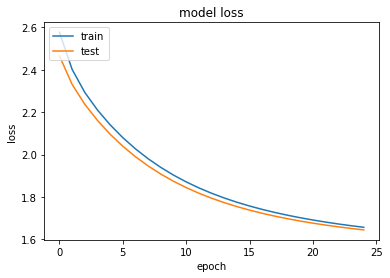

156/156 [==============================] - 2s 12ms/step - loss: 1.6442 - accuracy: 0.4838 - sparse_top_k_categorical_accuracy: 0.7756
Result on validation data:  {'loss': 1.6441632509231567, 'accuracy': 0.4837740361690521, 'sparse_top_k_categorical_accuracy': 0.7756410241127014}
312/312 [==============================] - 4s 12ms/step - loss: 1.6579 - accuracy: 0.4757 - sparse_top_k_categorical_accuracy: 0.7631
Result on test data:  {'loss': 1.6578705310821533, 'accuracy': 0.4756610691547394, 'sparse_top_k_categorical_accuracy': 0.7631210088729858}


In [ ]:
train_model(model, 25)

In [ ]:
model_lstm = models.Sequential()
model_lstm.add(layers.Input(shape=max_len))
model_lstm.add(layers.Embedding(vocab_size, max_len))
model_lstm.add(layers.LSTM(256))
model_lstm.add(layers.Dense(outdim_size, activation='softmax'))
model_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1566000   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                3855      
Total params: 1,935,423
Trainable params: 1,935,423
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_data, val_data, test_data = load_data(True, False)

Epoch 1/25
1093/1093 [==============================] - ETA: 0s - loss: 2.5174 - accuracy: 0.1687 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.3856
Epoch 00001: val_loss improved from inf to 2.47153, saving model to temp_weights.h5
1093/1093 [==============================] - 31s 29ms/step - loss: 2.5174 - accuracy: 0.1687 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.3856 - val_loss: 2.4715 - val_accuracy: 0.1759 - val_lr: 1.0000e-04 - val_sparse_top_k_categorical_accuracy: 0.4255
Epoch 2/25
1092/1093 [============================>.] - ETA: 0s - loss: 2.3772 - accuracy: 0.1958 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.4514
Epoch 00002: val_loss improved from 2.47153 to 2.24810, saving model to temp_weights.h5
1093/1093 [==============================] - 29s 27ms/step - loss: 2.3770 - accuracy: 0.1958 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.4516 - val_loss: 2.2481 - val_accuracy: 0.2380 - val_lr: 1.0000e-04 - val_sparse_top_k_categoric

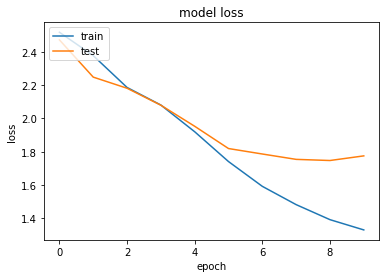

156/156 [==============================] - 1s 4ms/step - loss: 1.7478 - accuracy: 0.4387 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.7246
Result on validation data:  {'loss': 1.7477893829345703, 'accuracy': 0.43870192766189575, 'lr': 9.999988105846569e-05, 'sparse_top_k_categorical_accuracy': 0.7245593070983887}
312/312 [==============================] - 2s 5ms/step - loss: 1.7340 - accuracy: 0.4426 - lr: 1.0000e-04 - sparse_top_k_categorical_accuracy: 0.7214
Result on test data:  {'loss': 1.7340466976165771, 'accuracy': 0.44260817766189575, 'lr': 9.999985195463523e-05, 'sparse_top_k_categorical_accuracy': 0.7213541865348816}


In [ ]:
train_model(model_lstm, 25)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
def load_cat(newdata, tfrecord_path = "new.tfrecord", keras_hub=False):
    data = load_csv()
    token, _ = get_token(data[0].Descriptions)
    
    dataset = []
    for i in range(outdim_size):
        tfrecord_path = "test_cat"+str(i)+".tfrecord"
        write_tfrecord(newdata[i], token, tfrecord_path, keras_hub)
        dataset.append(get_dataset(tfrecord_path, keras_hub))

    return dataset

In [ ]:
tedf = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')
cat_tup = tedf.groupby(["cat_id", "Genre"]).count().index.values
cat_dict=dict() 
for cat_id,cat in cat_tup: 
    cat_dict[cat_id] = cat
print(cat_dict)

{0: 'Adventure', 1: 'Arcade', 2: 'Fighting', 3: 'Indie', 4: 'Music', 5: 'Pinball', 6: 'Platform', 7: 'Puzzle', 8: 'Quiz/Trivia', 9: 'Racing', 10: 'Role-playing(RPG)', 11: 'Shooter', 12: 'Simulator', 13: 'Sport', 14: 'Strategy'}


In [ ]:
_,_,df = load_csv() # load train data 
#df = tedf
print("...df loaded")
BATCH_SIZE = 32
results = []
newdata = []

# seperate data based on category
for i in range(outdim_size):
  newdata.append(df[df.cat_id==i])

# write tfrecord file and load dataset outdim_siz number of dataset
dataset = load_cat(newdata, keras_hub=True)
print("...dataset loaded")

...df loaded
...dataset loaded


In [ ]:
cat_sample_size = df.groupby(["Genre", "cat_id"]).count().Descriptions

from collections import Counter

# each iteration the below code will count the predic and apend in the prediction list
pred_count = []
# list of dataframe that contains the prediction layer for each category
prob_df_list = []
for i in range(outdim_size):
  steps = cat_sample_size[i] // 32
  prob_y = model.predict(dataset[i].repeat(), steps=steps)
  pred_y = tf.argmax(prob_y, 1)
  pred_count.append(Counter(pred_y.numpy()))

  feat_cols = ['f'+str(k) for k in range(prob_y.shape[1])]
  prob_df = pd.DataFrame(prob_y,columns=feat_cols)
  prob_df["genre"] = [cat_dict[i] for k in range(prob_y.shape[0])]
  prob_df_list.append(prob_df)

# put all the predict into confusion matrix where row is truth value
conf_mat = pd.DataFrame(pred_count, columns=range(outdim_size))
conf_mat.fillna(0, inplace=True)

# prediction layer with true category
prob_df = pd.concat(prob_df_list, ignore_index=True, sort=False)

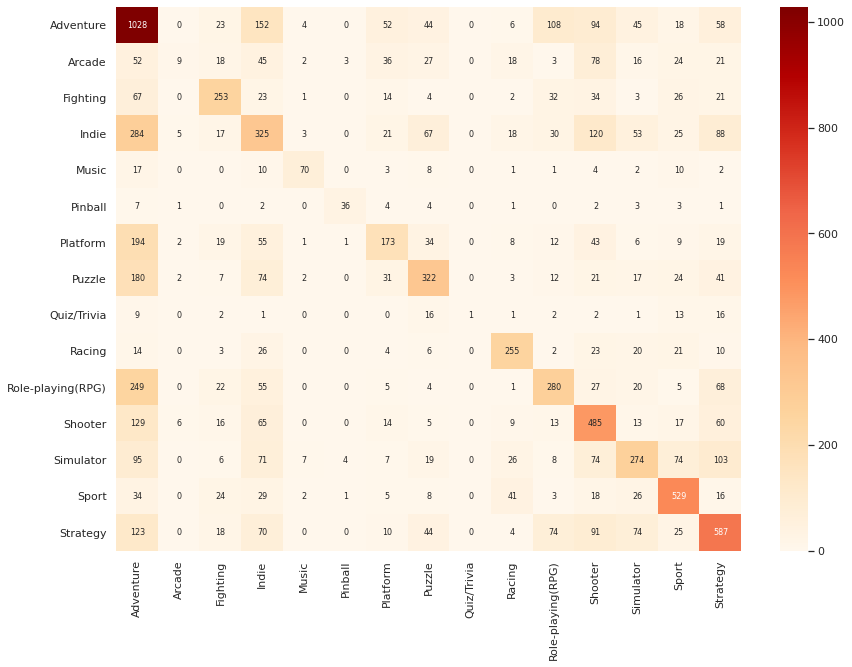

In [ ]:
df_cm = pd.DataFrame(conf_mat.values.astype(int), cat_dict.values(), cat_dict.values())
plt.figure(figsize=(14,10))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True,fmt='d', annot_kws={"size": 8}, cmap="OrRd") # font size

plt.savefig("filename.png")
plt.show()

In [ ]:
print('Universal Sentence Encoder accuracy by genre:')
for i in range(outdim_size):
  acc = conf_mat.values[i,i]/sum(conf_mat.loc[i,:])
  print(cat_dict[i]," (",str(i), "): ",  str(acc*100), " %")

Universal Sentence Encoder accuracy by genre:
Adventure  ( 0 ):  62.99019607843137  %
Arcade  ( 1 ):  2.556818181818182  %
Fighting  ( 2 ):  52.708333333333336  %
Indie  ( 3 ):  30.77651515151515  %
Music  ( 4 ):  54.6875  %
Pinball  ( 5 ):  56.25  %
Platform  ( 6 ):  30.03472222222222  %
Puzzle  ( 7 ):  43.75  %
Quiz/Trivia  ( 8 ):  1.5625  %
Racing  ( 9 ):  66.40625  %
Role-playing(RPG)  ( 10 ):  38.04347826086957  %
Shooter  ( 11 ):  58.293269230769226  %
Simulator  ( 12 ):  35.67708333333333  %
Sport  ( 13 ):  71.875  %
Strategy  ( 14 ):  52.41071428571429  %
